ЦЕЛЬ
Исследовать поведение пользователей в обновлённом приложении.

ЗАДАЧИ
В рамках проверки гипотез нам необходимо решить три задачи:

1. Определить, насколько обучение сокращает время прохождения этапов игры.
2. Доказать, что успешное обучение само по себе влияет на оплату и не имеет значения то, каким этапом оно шло.
3. Определить, насколько прозрачен процесс взаимодействия с игрой.

КОНКРЕТНЫЕ ШАГИ (ФОРМАЛИЗОВАННЫЕ ЗАДАЧИ)
1. Сравнить время прохождения различных этапов для пользователей, которые завершили обучение, и пользователей, не начинавших обучение. Если показатель отличается, выяснить, насколько.
2. Проверить, существует ли зависимость между вероятностью оплаты вопросов и количеством обучений, которые начинал или завершал пользователь. 
3. Выяснить, как часто пользователи начинают обучение после выбора уровня сложности. (Это позволит оценить прозрачность процесса взаимодействия с игрой: если пользователи после выбора уровня сложности обращаются к обучению, значит, работа с приложением непонятна.)

In [170]:
import pandas as pd
import warnings
warnings.filterwarnings('ignore')

import seaborn as sb
import matplotlib.pyplot as plt
%matplotlib inline

import plotly
import plotly.express as px

Открываем наши данные и приводим их к нужному виду: 
1. приводим слоблец с датой и временем к нужному формату
2. создаем фильтр позволяющий сделать выборку пользователей, которые зарегестрировались в 2018 году. 
3. преименовываем столбцы в датафреймах, а далее соединяем в единую таблицу 

In [171]:
event = pd.read_csv('/Users/yanaprynik/Work_doc/gd3/Events.csv', sep=',') # импортируем файлы
purchase = pd.read_csv('/Users/yanaprynik/Work_doc/gd3/purchase.csv', sep=',')

event['start_time'] = pd.to_datetime(event['start_time'], errors='coerce') # приводим даты в нужный нам формат
purchase['event_datetime'] = pd.to_datetime(purchase['event_datetime'])

date_mask_events = (event['start_time'] >= '2018-01-01') & (event['start_time'] < '2019-01-01') # создаем маску для фильтра пользователей
reg_events = (event['event_type'] == 'registration')
user_2018 = event[date_mask_events][reg_events]['user_id'].to_list()
event = event[event['user_id'].isin(user_2018)] # фильтруем нашу таблицу и выбираем только пользователей зарегестрировавшихся в 2018 году

purchase = purchase[purchase['user_id'].isin(user_2018)] # делаем тоже самое и со второй таблицей
purchase['event_type'] = 'purchase' # добавляем новый тип ивента

event = event.rename(columns={"id": "event_id"}) # переименовываем колонки
purchase = purchase.rename(columns={"id": "purchase_id", "event_datetime": "start_time"})

total_events_df = pd.concat([event,purchase],sort=False) # соединяем наши таблицы
total_events_df = total_events_df.reset_index(drop=True).sort_values('start_time') # удаляем индексы и сортируем по времени
total_events_df.head(10)


,event_id,event_type,selected_level,start_time,tutorial_id,user_id,purchase_id,amount
0,80308.0,registration,NaN,2018-01-01 03:48:40,NaN,27832,NaN,NaN
1,80309.0,registration,NaN,2018-01-01 04:07:25,NaN,27833,NaN,NaN
2,80310.0,registration,NaN,2018-01-01 08:35:10,NaN,27834,NaN,NaN
3,80311.0,registration,NaN,2018-01-01 11:54:47,NaN,27835,NaN,NaN
4,80312.0,registration,NaN,2018-01-01 13:28:07,NaN,27836,NaN,NaN
5,80313.0,registration,NaN,2018-01-01 14:08:40,NaN,27837,NaN,NaN
6,80314.0,registration,NaN,2018-01-01 14:42:58,NaN,27838,NaN,NaN
7,80315.0,tutorial_start,NaN,2018-01-01 14:54:40,31505.0,27836,NaN,NaN
8,80316.0,tutorial_start,NaN,2018-01-01 15:00:51,31506.0,27835,NaN,NaN
9,80317.0,tutorial_finish,NaN,2018-01-01 15:06:15,31506.0,27835,NaN,NaN


1. создадим вспомогательные датафреймы со временем начала того или иного этапа игры 

In [172]:
registration_df = total_events_df[total_events_df['event_type'] == 'registration'] # Пользователи которые прошли регистрацию


tutorial_start_df = total_events_df[total_events_df['event_type'] == 'tutorial_start']
tutorial_start_df_wo_duplicates = tutorial_start_df.sort_values("start_time").drop_duplicates("user_id")
tutorial_finish = total_events_df[total_events_df["event_type"] == "tutorial_finish"]
first_tutorial_ids = tutorial_start_df_wo_duplicates["tutorial_id"].unique()
tutorial_finish_df = tutorial_finish[tutorial_finish["tutorial_id"].isin(first_tutorial_ids)] # Пользователи которые прошли обучение


users_with_started_tutorial = tutorial_start_df['user_id'].unique()
set_users_with_started_tutorial = set(users_with_started_tutorial)
all_users = total_events_df["user_id"].unique()
set_all_users = set(all_users)
set_users_not_started_tutorial = set_all_users.difference(
    set_users_with_started_tutorial)
not_tutorial_user_df = registration_df[registration_df['user_id'].isin(set_users_not_started_tutorial)] # Пользователи которые не прошли обучение

display(not_tutorial_user_df)
level_choice_df = total_events_df[total_events_df['event_type'] == 'level_choice'] # Пользователи которые выбрали уровень сложности

pack_choice_df = total_events_df[total_events_df['event_type'] == 'pack_choice'] # Пользователи которые выбрали бесплатный пак вопросов 

purchase_df = total_events_df[total_events_df['event_type'] == 'purchase'] # Пользователи которые купили платный пак вопросов 


,event_id,event_type,selected_level,start_time,tutorial_id,user_id,purchase_id,amount
0,80308.0,registration,NaN,2018-01-01 03:48:40,NaN,27832,NaN,NaN
5,80313.0,registration,NaN,2018-01-01 14:08:40,NaN,27837,NaN,NaN
6,80314.0,registration,NaN,2018-01-01 14:42:58,NaN,27838,NaN,NaN
27,80335.0,registration,NaN,2018-01-02 00:13:22,NaN,27844,NaN,NaN
37,80345.0,registration,NaN,2018-01-02 06:05:02,NaN,27848,NaN,NaN
...,...,...,...,...,...,...,...,...
66936,147244.0,registration,NaN,2018-12-31 12:03:59,NaN,47749,NaN,NaN
66938,147246.0,registration,NaN,2018-12-31 13:42:40,NaN,47750,NaN,NaN
66940,147248.0,registration,NaN,2018-12-31 18:49:30,NaN,47752,NaN,NaN
66942,147250.0,registration,NaN,2018-12-31 19:14:08,NaN,47754,NaN,NaN


In [173]:
registration_df = registration_df[["user_id", "start_time"]].rename(columns={"start_time": "registration_time"}) # переименуем столбец со временем

tutorial_finish_df = tutorial_finish_df[["user_id", "start_time"]].rename(columns={"start_time": "tutorial_finish_time"})

not_tutorial_user_df = not_tutorial_user_df[["user_id", "start_time"]].rename(columns={"start_time": "registration_finish_time"})

level_choice_df = level_choice_df[["user_id", "start_time"]].rename(columns={"start_time": "level_choice_time"})

pack_choice_df = pack_choice_df[["user_id", "start_time"]].rename(columns={"start_time": "pack_choice_time"})

purchase_df = purchase_df[["user_id", "start_time"]].rename(columns={"start_time": "purchase_time"})

проверим количество прользователей, построив воронку приложения. 

In [174]:
display(registration_df['user_id'].value_counts().sum())
display(tutorial_finish_df['user_id'].value_counts().sum())
display(not_tutorial_user_df['user_id'].value_counts().sum())
display(level_choice_df['user_id'].value_counts().sum())
display(pack_choice_df['user_id'].value_counts().sum())
display(purchase_df['user_id'].value_counts().sum())

19926

9830

8068

8342

5737

1600

у нас есть данные о пользователях: 
1. Закончили обучение
2. Не начинали обучение
3. Выбрали уровень сложность
4. Выбрали бесплатный пакет вопросов
5. Купили платный пакет вопросов

Сравниваем время прохождения различных этапов для пользователей, которые завершили обучение, и пользователей, не начинавших обучение.

,user_id,tutorial_finish_time,level_choice_time
0,27835,2018-01-01 15:06:15,2018-01-01 20:37:22
1,27839,2018-01-01 19:16:32,2018-01-01 22:37:50
2,27845,2018-01-02 03:06:48,2018-01-02 06:19:18
3,27842,2018-01-02 04:57:01,2018-01-02 08:46:03
4,27849,2018-01-02 09:11:45,2018-01-02 11:53:11
...,...,...,...
7192,47732,2018-12-31 07:21:02,2018-12-31 09:59:00
7193,47747,2018-12-31 10:22:45,2018-12-31 12:24:40
7194,47753,2018-12-31 20:57:07,2018-12-31 22:36:19
7195,47755,2019-01-01 00:09:30,2019-01-01 05:04:52


98

tutorial
finish tutorial        2.335005
not finish tutorial    5.259201
Name: timedelta, dtype: float64

Text(0.5, 1.0, 'Время до выбора уровня сложности')

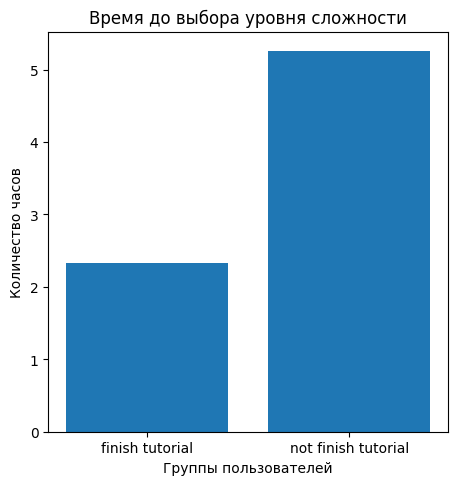

In [175]:
df_level_choise_finish_tutorial = tutorial_finish_df.merge(
    level_choice_df, 
    on='user_id', 
    how='inner'
    ) # объединяем датафреймы, тех кто завершил обучение и выбора уровня сложности.
display(df_level_choise_finish_tutorial)
cnt_user_level_choise_finish_tutorial = df_level_choise_finish_tutorial.value_counts().sum() # проверяем сколько пользоватетелй перешли на след. этап
df_level_choise_finish_tutorial['timedelta'] = df_level_choise_finish_tutorial['level_choice_time']- df_level_choise_finish_tutorial['tutorial_finish_time']
df_level_choise_finish_tutorial['tutorial'] = 'finish tutorial'


df_level_choise_not_finish_tutorial = not_tutorial_user_df.merge(
    level_choice_df, 
    on='user_id', 
    how='inner'
    ) # объединяем датафреймы, тех кто не начинал обучение и выбора уровня сложности.

cnt_user_level_choise_no_finish_tutorial = df_level_choise_not_finish_tutorial.value_counts().sum() # проверяем сколько пользоватетелй перешли на след. этап
df_level_choise_not_finish_tutorial['timedelta'] = df_level_choise_not_finish_tutorial['level_choice_time'] - df_level_choise_not_finish_tutorial['registration_finish_time']
df_level_choise_not_finish_tutorial['tutorial'] = 'not finish tutorial'
display(cnt_user_level_choise_no_finish_tutorial)


time_level_choise = df_level_choise_finish_tutorial.merge(
    df_level_choise_not_finish_tutorial, 
    on=['timedelta', 'tutorial'],
    how='outer'
)   # объединяем датафреймы
time_level_choise['timedelta'] = time_level_choise['timedelta'] / pd.to_timedelta('1 hour') 
time_level_choise = time_level_choise.groupby('tutorial')['timedelta'].mean() # группируем нашу таблицу
display(time_level_choise)

fig = plt.figure(figsize=(4, 4)) #  строим график, где показано какое количество часов необходимо было для выбора уровня сложности
main_axes = fig.add_axes([0, 0, 1, 1])
main_axes.bar(
    x = time_level_choise.index,
    height = time_level_choise,
    
    )
main_axes.set_ylabel('Количество часов')
main_axes.set_xlabel('Группы пользователей')
main_axes.set_title('Время до выбора уровня сложности')

как мы можем видеть, пользователи перешедшие на следуйщий этап выбора уровня сложности, очень сильно отличаеются в наших группах. Тех кто прошел обучение в разы больше, к тому же они быстрее приступают к выбору сложности. Те кто не прошел обучение счилались от момента регистрации.

Далее производим аналогичную сортировку данных и уже строим графики по другим этапам игры. 

Решил сделать таким образом, что бы в дальнейшем, можно было взять любой датафрейм пользователей и уже работать в разрезе по этапам игры. 
Для любых метрик необходимо будет добавить только столбцы в начальные отсортированные таблицы (момент переименовывания start_time).

4976

74

tutorial
finish tutorial        5.307737
not finish tutorial    5.397072
Name: timedelta, dtype: float64

Text(0.5, 1.0, 'Время до выбора пакета вопросов')

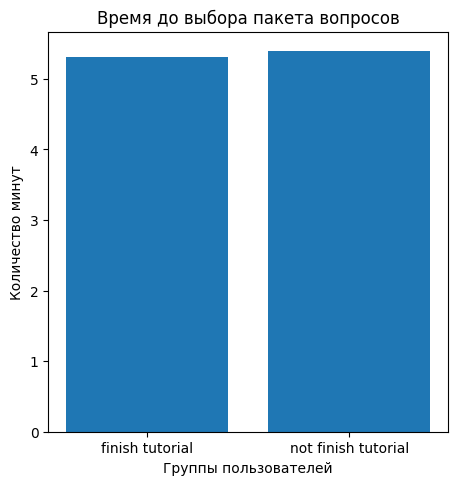

In [176]:
df_pack_choise_finish_tutorial = df_level_choise_finish_tutorial.merge(
    pack_choice_df,
    on='user_id',
    how='inner'
)
df_pack_choise_finish_tutorial['timedelta'] = df_pack_choise_finish_tutorial['pack_choice_time'] - df_pack_choise_finish_tutorial['level_choice_time']
cnt_pack_finish_tutorial = df_pack_choise_finish_tutorial.value_counts().count()
df_pack_choise_finish_tutorial['tutorial'] = 'finish tutorial'

display(cnt_pack_finish_tutorial)



df_pack_choise_not_finish_tutorial = df_level_choise_not_finish_tutorial.merge(
    pack_choice_df,
    on='user_id',
    how='inner'
)
df_pack_choise_not_finish_tutorial['timedelta'] = df_pack_choise_not_finish_tutorial['pack_choice_time'] - df_pack_choise_not_finish_tutorial['level_choice_time']
cnt_pack_not_finish_tutorial = df_pack_choise_not_finish_tutorial.value_counts().count()
df_pack_choise_not_finish_tutorial['tutorial'] = 'not finish tutorial'

display(cnt_pack_not_finish_tutorial)

time_pack_choise = df_pack_choise_finish_tutorial.merge(
    df_pack_choise_not_finish_tutorial, 
    on=['timedelta', 'tutorial'],
    how='outer'
)
time_pack_choise['timedelta'] = time_pack_choise['timedelta'] / pd.to_timedelta('1 minutes')
time_pack_choise = time_pack_choise.groupby('tutorial')['timedelta'].mean()
display(time_pack_choise)

fig = plt.figure(figsize=(4, 4))
main_axes = fig.add_axes([0, 0, 1, 1])
main_axes.bar(
    x = time_pack_choise.index,
    height = time_pack_choise,
    
    )
main_axes.set_ylabel('Количество минут')
main_axes.set_xlabel('Группы пользователей')
main_axes.set_title('Время до выбора пакета вопросов')

Следуйщий этап выбора бесплатного пака вопросов, пользователи показали практически равное время, а отток пользоватей произошол в 31% для прошелших обучение и 25% для тех, кто не проходил, по сравнению с предыдущим этапом игры.

1387

Timedelta('3 days 17:13:47.798125450')

22

Timedelta('4 days 04:49:33.590909090')

Text(0.5, 1.0, 'Время до покупки пакета вопросов')

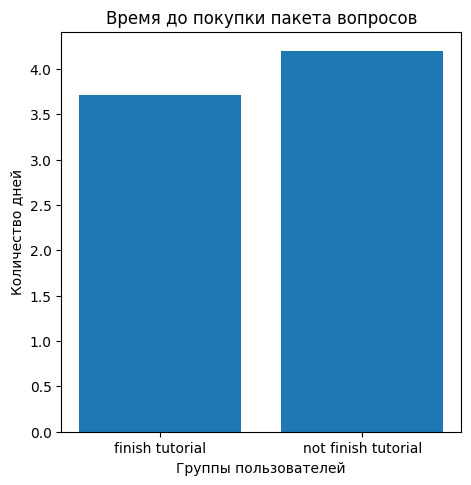

In [177]:
df_purchase_finish_tutorial = df_pack_choise_finish_tutorial.merge(
    purchase_df,
    on='user_id',
    how='inner'
)
df_purchase_finish_tutorial['timedelta'] = df_purchase_finish_tutorial['purchase_time'] - df_purchase_finish_tutorial['pack_choice_time']
cnt_purchase_finish_tutorial = df_purchase_finish_tutorial.value_counts().count()
df_purchase_finish_tutorial['tutorial'] = 'finish tutorial'
display(cnt_purchase_finish_tutorial)
display(df_purchase_finish_tutorial.timedelta.mean())



df_purchase_not_finish_tutorial = df_pack_choise_not_finish_tutorial.merge(
    purchase_df,
    on='user_id',
    how='inner'
)
df_purchase_not_finish_tutorial['timedelta'] = df_purchase_not_finish_tutorial['purchase_time'] - df_purchase_not_finish_tutorial['pack_choice_time']
cnt_purchase_not_finish_tutorial = df_purchase_not_finish_tutorial.value_counts().count()
df_purchase_not_finish_tutorial['tutorial'] = 'not finish tutorial'
display(cnt_purchase_not_finish_tutorial)
display(df_purchase_not_finish_tutorial.timedelta.mean())

time_purchase = df_purchase_finish_tutorial.merge(
    df_purchase_not_finish_tutorial, 
    on=['timedelta', 'tutorial'],
    how='outer'
)
time_purchase['timedelta'] = time_purchase['timedelta'] / pd.to_timedelta('1 day')
time_purchase = time_purchase.groupby('tutorial')['timedelta'].mean()


fig = plt.figure(figsize=(4, 4))
main_axes = fig.add_axes([0, 0, 1, 1])
main_axes.bar(
    x = time_purchase.index,
    height = time_purchase,
    
    )
main_axes.set_ylabel('Количество дней')
main_axes.set_xlabel('Группы пользователей')
main_axes.set_title('Время до покупки пакета вопросов')

Покупка бесплатного пака от пользователей которые выбрали бесплатный пак составила: 28%, которые прошли обучение и 30% для тех, кто не прошел.  Разность во времени мнежду группами составила примерно 12 часов в пользу тех, кто прошел обучение

Timedelta('4 days 00:25:51.737563085')

Timedelta('4 days 09:06:01.909090909')

tutorial
finish tutorial        4.017960
not finish tutorial    4.379189
Name: timedelta, dtype: float64

Text(0.5, 1.0, 'Время с момента регистрации до покупки вопросов')

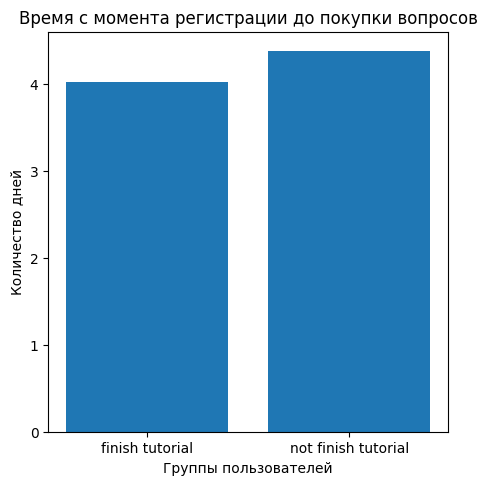

In [178]:
full_time_finish_tutorial = df_purchase_finish_tutorial.merge(
    registration_df,
    on='user_id',
    how='inner'
) # создаем датафрейм с момента регистрации и до покупки 
full_time_finish_tutorial['timedelta'] = full_time_finish_tutorial['purchase_time'] - full_time_finish_tutorial['registration_time']
full_time_finish_tutorial['tutorial'] = 'finish tutorial'
display(full_time_finish_tutorial.timedelta.mean())

full_time_not_finish_tutorial = df_purchase_not_finish_tutorial.merge(
    registration_df,
    on='user_id',
    how='inner'
)
full_time_not_finish_tutorial['timedelta'] = full_time_not_finish_tutorial['purchase_time'] - full_time_not_finish_tutorial['registration_time']
full_time_not_finish_tutorial['tutorial'] = 'not finish tutorial'
display(full_time_not_finish_tutorial.timedelta.mean())

full_time = full_time_finish_tutorial.merge(
    full_time_not_finish_tutorial,
    on=['timedelta', 'tutorial'],
    how='outer'
)
full_time['timedelta'] = full_time['timedelta'] / pd.to_timedelta('1 day')
full_time = full_time.groupby('tutorial')['timedelta'].mean()
display(full_time)

fig = plt.figure(figsize=(4, 4))
main_axes = fig.add_axes([0, 0, 1, 1])
main_axes.bar(
    x = full_time.index,
    height = full_time,
    
    ) # строим график так же по двум группам пользователей, и видим сколько времени необходимо с регистрации до оплаты.
main_axes.set_ylabel('Количество дней')
main_axes.set_xlabel('Группы пользователей')
main_axes.set_title('Время с момента регистрации до покупки вопросов')

В данном блоке кода, подсчитали общее время с момента регистрации, до момента покупки пользователей. Как можно заметить на это уходит в среднем 4 дня. Пользователи, которые все же прошли обучение, совершают этап покупки быстрее, чем те, кто не прошел. Это говорит о том, что обучение помогает вовлечению в игру. 

Из прошлых шагов, можно заметить, что пользователи, прошедшие обучение, быстрее переходили к выбору сложности.(да. можно сказать, что те, кто не проходил туториал считали время от момента регистрации, но это и логично, ведь они пропустили шаг и должны были сразу выбрать уровень.) 
Следуйший шаг, который показывает эффективность обучения - это покупка платного пака вопросов, у первый группы пользователей, она происходит быстрее на 12.5 часов.

In [179]:
purchase.groupby('user_id')['purchase_id'].value_counts().mean() # проверим сколько раз пользователи купили платный пакет

1.0

Как мы видим, более одной покупки пользователь не совершил. Тогда будем проверять на сколько дорогая была эта покупка. Не вижу смысла разбирать отдельных пользователей, поэтому обобщим все в группы по количеству прохождений обучения.

In [180]:
import seaborn as sns
import matplotlib.pyplot as plt

,user_id,amount_y,count
723,37496,150,1
922,40272,100,1
921,40268,200,1
920,40267,150,1
919,40250,100,1
...,...,...,...
134,29655,100,8
1071,42762,100,9
583,35713,50,9
131,29630,200,9


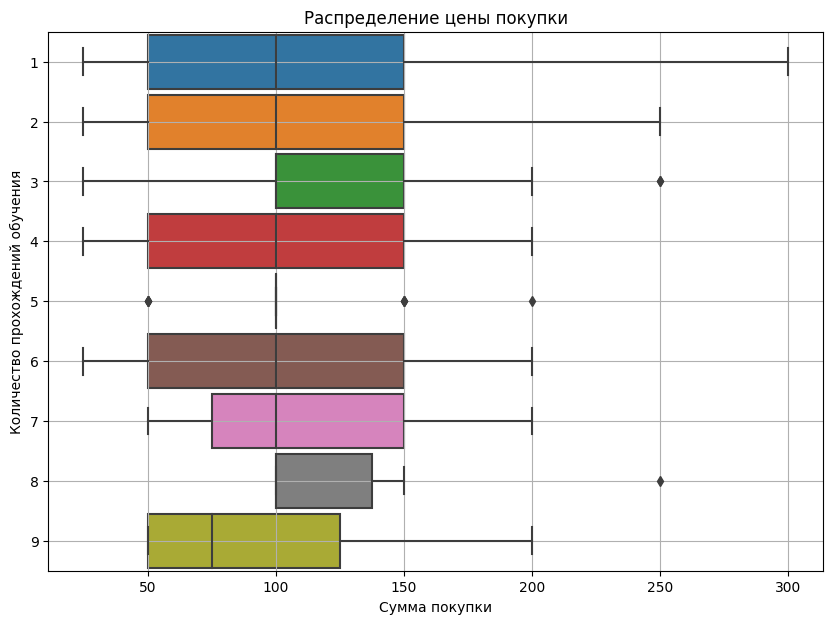

In [181]:
user_tutorial = total_events_df[total_events_df["event_type"] == "tutorial_finish"] # ищем игроков, которые прошли обучение


purchase_user = purchase.copy() # копируем таблицу c покупками для работы 

purchase_user = purchase_user[["user_id", "amount", "event_type"]].rename(columns={"event_type": "event_type2"}) # оставляем только нужные столбцы

cnt_tutorial_user = user_tutorial.merge(
    purchase_user,
    on='user_id',
    how='inner'
) # объединяем таблицы с помощью иннет, что бы оставить только тех пользователей, которые прошли обучение и провели оплату


top = cnt_tutorial_user.groupby(
    by='user_id',
    as_index=False
)['amount_y'].value_counts().sort_values(by='count') # групируем таблицу по пользователям и находим количество прохождений индивидуально для каждого 

display(top)

fig2 = plt.figure(figsize=(10, 7))
amount_rate = sns.boxplot(
    data=top,
    y='count',
    x='amount_y',
    orient='h',
    width=0.9
) # строим коробчатую диаграмму, что бы лучше разобрать наши группы пользователей по доходу
amount_rate.set_title('Распределение цены покупки');
amount_rate.set_xlabel('Сумма покупки');
amount_rate.set_ylabel('Количество прохождений обучения');
amount_rate.grid()


Как видно из графика, медианная сумма покупки равна практически для всех групп пользователей. Как и средняя сумма покупки. Так же из графика видно, что пользователи прошедшие 9 раз обучение, тратят меньше, чем все остальные, возможно это зависит из-за того, что мало человек попало в данную категорию. Отвечая на вопрос смело говорим, что количество обучений не влияет на качество и количество оплат.

,chogort,cnt_user,cnt_purchase_user,conversion
0,1,9103,1207,13
1,2,1589,218,14
2,3,427,51,12
3,4,221,30,14
4,5,109,16,15
5,6,116,14,12
6,7,94,12,13
7,8,86,13,15
8,9,113,17,15


Text(0.5, 1.0, 'Конверсия пользователей начавших обучение')

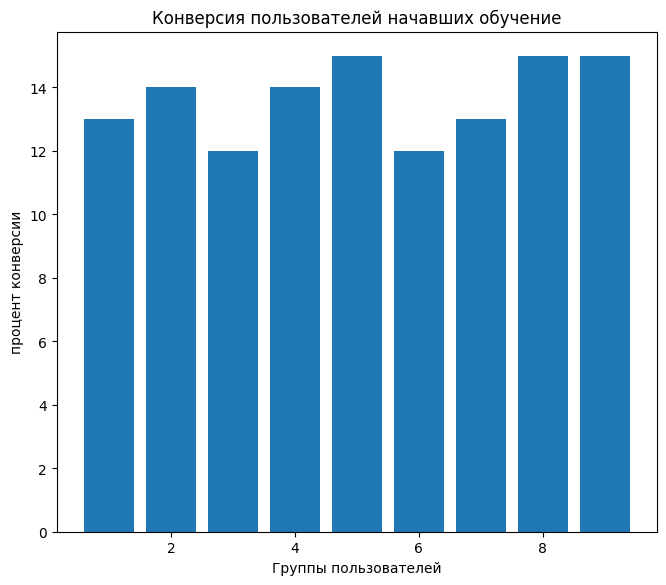

In [182]:
user_tutorial = total_events_df[total_events_df['event_type'] == 'tutorial_start'] # определяем группу пользователей, которые начали оучение

user_tutorial = user_tutorial.groupby('user_id', as_index=False)['event_type'].value_counts().sort_values(by='count')
user_tutorial_cnt1 = user_tutorial.groupby('count', as_index=False)['user_id'].count() #  сортируем и строим когорты по кол-ву прохождени обучений

purchase_tutorial = user_tutorial.merge(purchase, on='user_id', how='inner')
user_tutorial = user_tutorial.merge(purchase, on='user_id', how='inner')
user_tutorial_cnt2 = user_tutorial.groupby('count', as_index=False)['user_id'].count()

user_tutorial_cnt3 = user_tutorial_cnt1.merge(user_tutorial_cnt2, on='count') # так же считаем кол-во этих пользовтелей в таблице оплат, с помощию объединеня

user_tutorial_cnt3['conversion'] = round(user_tutorial_cnt3['user_id_y'] / user_tutorial_cnt3['user_id_x'] * 100)
user_tutorial_cnt3['conversion'] = user_tutorial_cnt3['conversion'].astype('int64')
user_tutorial_cnt3 = user_tutorial_cnt3.rename(columns={'user_id_x' : 'cnt_user', 'user_id_y' : 'cnt_purchase_user', 'count' : 'chogort'})
display(user_tutorial_cnt3) # считаем конверсию пользователей, приводим в нужный тип данных, для построения графика

fig = plt.figure(figsize=(6, 5))
convers_axes = fig.add_axes([0, 0, 1, 1])
convers_axes.bar(
    x = user_tutorial_cnt3.chogort,
    height = user_tutorial_cnt3.conversion,
    
    ) # строим график по  группам пользователей, и видим конверсию с количеств прохождения обучения до оплаты.
convers_axes.set_ylabel('процент конверсии')
convers_axes.set_xlabel('Группы пользователей')
convers_axes.set_title('Конверсия пользователей начавших обучение')


Из графика видно, что конверсия пользователей не сильно отличается от показателей оплаты. в среднем - это для всех групп 12.5%. Но вот уже пользователи последних групп (8 и 9), показывают наилучшие показатели конверсии. Но средняя сумма покупки ниже, чем у других пользователей.

In [183]:
tutorial_start_df = tutorial_start_df[['user_id', 'start_time']]
level_choice_df = level_choice_df[['user_id', 'level_choice_time']] #  создаем таблицы для работы 

cnt_slow_tutorial = tutorial_start_df.merge(
    level_choice_df,
    on='user_id',
    how='inner'
    ) #  объединяем их

cnt_slow_tutorial['timedelta'] = cnt_slow_tutorial['start_time'] - cnt_slow_tutorial['level_choice_time'] #  ищем разницу во времени, если положительная, то искомый случай
cnt_slow_tutorial['user_id'] = cnt_slow_tutorial['user_id'].nunique() #  оставляем только уникальныйх позьзователей

x = pd.Timedelta('1 second') # создадим переменную для посчета

def time(time):
    cnt_user = 0
    if time > x:
        cnt_user +=1 
    return cnt_user

cnt_user = cnt_slow_tutorial['timedelta'].apply(time) #  считаем кол-во пользовтелей, которые начали обучение после выбора уровня сложности

cnt_user = cnt_user.sum()  
print(cnt_user / tutorial_start_df['user_id'].count() * 100)  # считаем процент пользователей, от кол-ва пользователей, начавших обучение

15.468144044321331


Мы получили 15.5% таких пользователей. Что говорит о том, что игра немного не понятна для отдельных людей. Процент не высокий, но если его уменьшит, можно увеличить конверсию пользователей на несколько процентов. Что положительно скажется на доходе.

# Вывод
1. В ходе исследования мы изучили пусть пользовтелей, которые прошли обучение и тех, кто не проходил его. Исходя из графиков и разбора каждого пусти, средние показатели были практически равны, кроме выбора уровня сложности и до покупки платного пакета. Но в целом, показатели равны.
Общая разница с момента регистрации составила 9 часов, соответсвенно пользватели прошедшие обучение быстрее сделали покупку.

2. Далее разбирали конверсию покупок и качество оплат, пользователей, которые прошли обучение от одного до девяти раз. На графиках видно, что разница среди когорт не сильно велика. Медианный показатель покупок у всех групп одинаковый и межквартильный размах, так же. Выделяются 8 и 9 группы, которые прошли соответсвующее ко-во раз обучение. Процент конверсии до покупки у них самый высокий.

3. И третий вопрос, на сколько прозрачна игра, для пользователя. Для этого нашли пользователей, которые начали обучение, уже после выбора уровня сложность, и посчитали процент таких пользователей в 15.5% от общего кол-ва игроков, которые начали обучение. Процент не высокий, но если его уменьшит, можно увеличить конверсию пользователей на несколько процентов.


4. Пользователи в игре показывают стабильные цыфры и нельзя заменить какую, либо закономерность. Игра простая и интуитивно понятная для большинства. Показатели конверсии хорошие. Единственный  вопрос, почему пользователи в среднем делают только одну покупку.